<!-- :Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu> -->
<!-- :Date: 2020-07-13 -->
<!-- :Copyright: 2020, Karr Lab -->
<!-- :License: MIT -->

# A stochastic epidemic model

Epidemics occur when infectious diseases spread through a susceptible population.
Models that classify individuals by their infectious state are widely used to analyze and predict the dynamics of epidemics.
A well-known and simple approach considers these three infectious states:

* *Susceptible*: an individual who can become infected if exposed
* *Infectious*: an individual who is infected, and can transmit the infection to a person who is susceptible
* *Recovered*: an individual who has recovered from an infection, and is not susceptible to being reinfected

Dynamic analyses of spreading infection that employ these states are called Susceptible, Infectious, or Recovered (SIR) epidemic models.
SIR models are characterized by the initial population of individuals in each state and the rate at which individuals transition between states.

![SIR model states and transitions](SIR_Flow_Diagram.svg)
*SIR model states and transitions*<sup>1</sup>

In this figure, the transitions between states are labeled with the standard SIR transition rates, in individuals per unit time.
S and I represent the number of individuals in states Susceptible and Infectious, respectively. &beta; and &gamma; are model parameters.

We present a stochastic SIR model that demonstrates core features of DE-Sim.
Epidemics must be modelled stochastically when the number of infectious individuals is small or when variability in the rates of transitions between model states influences an epidemic's trajectory.

The SIR model below uses DE-Sim to implement a continuous-time Markov chain model, as described in section 3 of Allen (2017).
It represents transitions by individuals to a new state as discrete events and selects each transition and its timing by random samples of their distributions.
See Allen (2017) for a mathematical derivation of the approach.

Let's implement and use the SIR model.
First, use `pip` to install `de_sim`.

1: Diagram by Viki Male and remade by Gregory Kaiser, licensed under [Creative Commons license]().

In [1]:
!pip install de_sim

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_internal/commands/install

In [2]:
""" Example DE-Sim implementations of stochastic Susceptible, Infectious, or Recovered (SIR) epidemic models

:Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu>
:Date: 2020-07-08
:Copyright: 2020, Karr Lab
:License: MIT
"""

import enum
import numpy

from de_sim.event import Event
from de_sim.simulation_engine import SimulationEngine
from de_sim.simulation_message import SimulationMessage
from de_sim.simulation_object import ApplicationSimulationObject


class StateTransition(SimulationMessage):
    "State transition"
    attributes = ['transition']


class RecordTrajectory(SimulationMessage):
    "Record trajectory"


class Transition(enum.Enum):
    """ Transition values
    """
    s_to_i = enum.auto()
    i_to_r = enum.auto()


MESSAGE_TYPES = [StateTransition, RecordTrajectory]


class SIR(ApplicationSimulationObject):
    """ Implement a Susceptible, Infectious, or Recovered (SIR) epidemic model

    This example uses DE-Sim to implement a continuous-time Markov chain (CTMC) SIR
    epidemic model, as described in section 3 of Allen (2017).

    Allen, L.J., 2017. A primer on stochastic epidemic models: Formulation, numerical
    simulation, and analysis. Infectious Disease Modelling, 2(2), pp.128-142.

    Attributes:
        s (:obj:`int`): number of susceptible subjects
        i (:obj:`int`): number of infectious subjects
        N (:obj:`int`): total number of susceptible subjects, a constant
        beta (:obj:`float`): SIR beta parameter
        gamma (:obj:`float`): SIR gamma parameter
        recording_period (:obj:`float`): time step for recording state
        random_state (:obj:`numpy.random.RandomState`): a random state
        history (:obj:`list`): list of recorded states
    """
    def __init__(self, name, s, i, N, beta, gamma, recording_period):
        """ Initialize a SIR instance

        Args:
            name (:obj:`str`): the instance's name
            s (:obj:`int`): initial number of susceptible subjects, s(0)
            i (:obj:`int`): initial number of infectious subjects, i(0)
            N (:obj:`int`): total number of susceptible subjects, a constant
            beta (:obj:`float`): SIR beta parameter
            gamma (:obj:`float`): SIR gamma parameter
            recording_period (:obj:`float`): time step for recording state
            random_state (:obj:`numpy.random.RandomState`): random state
            history (:obj:`list`): list of recorded states
        """
        self.s = s
        self.i = i
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.recording_period = recording_period
        self.random_state = numpy.random.RandomState()
        self.history = []
        super().__init__(name)

    def init_before_run(self):
        """ Initialize before a simulation run. Send the initial events, and record the initial state.
        """
        self.schedule_next_event()
        self.record_trajectory(None)

    def schedule_next_event(self):
        """ Schedule the next SIR event
        """
        rates = {'s_to_i': self.beta * self.s * self.i / self.N,
                 'i_to_r': self.gamma * self.i}
        lambda_val = rates['s_to_i'] + rates['i_to_r']
        if lambda_val == 0:
            return

        tau = self.random_state.exponential(1.0/lambda_val)
        prob_s_to_i = rates['s_to_i'] / lambda_val
        if self.random_state.random_sample() < prob_s_to_i:
            self.send_event(tau, self, StateTransition(Transition.s_to_i))
        else:
            self.send_event(tau, self, StateTransition(Transition.i_to_r))

    def handle_state_transition(self, event):
        """ Handle an infectious state transition

        Args:
            event (:obj:`Event`): simulation event that contains the type of transition
        """
        transition = event.message.transition
        if transition is Transition.s_to_i:
            self.s -= 1
            self.i += 1
        elif transition is Transition.i_to_r:
            self.i -= 1
        self.schedule_next_event()

    def record_trajectory(self, event):
        """ Add another record to the SIR history

        Args:
            event (:obj:`Event`): simulation event; not used
        """
        self.history.append(dict(time=self.time,
                                 s=self.s,
                                 i=self.i))
        self.send_event(self.recording_period, self, RecordTrajectory())

    event_handlers = [(StateTransition, 'handle_state_transition'),
                      (RecordTrajectory, 'record_trajectory')]

    # register the message types sent
    messages_sent = MESSAGE_TYPES

The next cell defines code to run the SIR model and visualize its predictions.

In [3]:
import pandas

class RunSIR(object):

    @staticmethod
    def main(time_max, **sir_args):

        # create a simulator
        simulator = SimulationEngine()

        # create a SIR instance
        sir = SIR(**sir_args)
        simulator.add_object(sir)

        # initialize simulation, which sends the SIR instance an initial event message
        simulator.initialize()

        # run the simulation
        num_events = simulator.simulate(time_max).num_events
        return sir

    @staticmethod
    def print_history(sir):
        header = ['time', 's', 'i', 'r']
        print('\t'.join(header))
        for state in sir.history:
            state_as_list = [state['time'], state['s'], state['i'],
                             sir.N - state['s'] - state['i']]
            state_as_list = [str(v) for v in state_as_list]
            print('\t'.join(state_as_list))

    @staticmethod
    def history_to_dataframe(sir):
        fields = ('s', 'i', 'r')
        hist = []
        index = []
        for state in sir.history:
            state_as_list = [state['s'], state['i'], sir.N - state['s'] - state['i']]
            hist.append(dict(zip(fields, state_as_list)))
            index.append(state['time'])
        return pandas.DataFrame(hist)

Let's use the model to view an epidemic's predictions.
We use parameters from Allen (2017), and print and plot the trajectory of a single simulation.
Since the model is stochastic, each run produces a different trajectory.

time	s	i	r
0	98	2	0
10	89	8	3
20	70	11	19
30	63	8	29
40	58	4	38
50	56	1	43
60	55	1	44
70	54	0	46
80	54	0	46
90	54	0	46
100	54	0	46


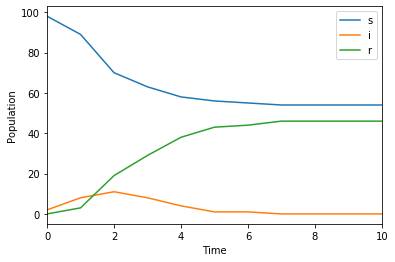

In [7]:
sir_args = dict(name='sir',
                s=98,
                i=2,
                N=100,
                beta=0.3,
                gamma=0.15,
                recording_period=10)
sir = RunSIR.main(100, **sir_args)

# print and plot an epidemic's predicted trajectory
RunSIR.print_history(sir)
sir_data_frame = RunSIR.history_to_dataframe(sir)
axes = sir_data_frame.plot()
axes.set_xlabel("Time")
rv = axes.set_ylabel("Population")

An important prediction generated by the SIR model is the severity of the epidemic, which can be summarized by the fraction of people who became infected.
We run an ensemble of simulations and examine the predicted distribution of severity.


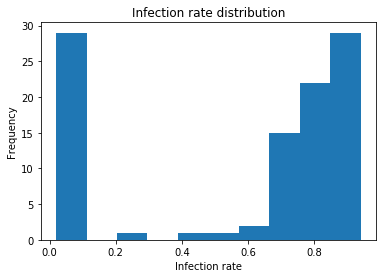

In [6]:
import math

num_sims = 100
infection_rates= []

for _ in range(num_sims):
    sir = RunSIR.main(100, **sir_args)
    # infection rate = infectious + recovered
    # N = s + i + r => i + r = N - s
    final_state = sir.history[-1]
    infection_rate = (sir.N - final_state['s'])/sir.N
    infection_rates.append(infection_rate)

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
rv = plt.hist(infection_rates)
ax.set_title('Infection rate distribution')
ax.set_xlabel('Infection rate')
rv = ax.set_ylabel('Frequency')

As predicted by Allen's (2017) analysis, for the parameters in `sir_args` the infection rate distribution is bimodal. Most of the epidemics infect a majority of the population and a small fraction of them (Allen predicts 25%) burn out and infect only a minority of the population.

The simple model above only touches the surface of epidemic modeling. Many extensions are possible:

* A spatial model with multiple geographic areas: each area would be represented by an instance of SIR.
* An extension of the spatial model that also represents travel between geographic areas
* A model that represents individuals in more states, such as multiple infectious states which distinguish between asymptomatic and symptomatic individuals, with a lower transmission parameter &beta; for symptomatic individuals who would likely isolate while recovering
* A model that can model both small and large populations: it would use the stochastic approach above to integrate small populations and ODEs to integrate large populations. Models and simulators that use multiple integration methods are called *multi-algorithmic*.

We encourage you to experiment with different parameters for this model and build your own models!

**References**

Allen, L.J., 2017. A primer on stochastic epidemic models: Formulation, numerical
simulation, and analysis. Infectious Disease Modelling, 2(2), pp.128-142.